In [ ]:
import torch
import torch.nn as nn
import math
from typing import Optional, Tuple

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config):
        """
        Args:
            config: Configuration object with n_heads, dim, attention_dropout.
        """
        super().__init__()
        self.config = config
        self.n_heads = config.n_heads
        self.dim = config.dim
        self.dropout = nn.Dropout(p=getattr(config, "attention_dropout", 0.0))

        if self.dim % self.n_heads != 0:
            raise ValueError(f"n_heads ({self.n_heads}) must divide dim ({self.dim})")

        self.attention_head_size = self.dim // self.n_heads

        # Standard Q, K, V linear layers
        self.q_lin = nn.Linear(self.dim, self.dim)
        self.k_lin = nn.Linear(self.dim, self.dim)
        self.v_lin = nn.Linear(self.dim, self.dim)
        self.out_lin = nn.Linear(self.dim, self.dim)

        # Gaussian sketch parameters
        self.linformer_k = 256  # Compressed sequence length
        self.gaussian_std = 1.0  # Standard deviation for Gaussian matrix

        # Register Gaussian matrices as buffers (they are not learnable parameters)
        self.register_buffer('gaussian_matrix_E', None)
        self.register_buffer('gaussian_matrix_F', None)

        # Optional scaling factors
        self.scale_gaussian = math.sqrt(1.0 / self.linformer_k)

    def _prepare_heads(self, x: torch.Tensor) -> torch.Tensor:
        """Reshapes the tensor for multi-head attention."""
        bs, seq_len, _ = x.size()
        return x.view(bs, seq_len, self.n_heads, self.attention_head_size).transpose(1, 2)

    def _create_gaussian_matrix(self, seq_len: int, device: torch.device) -> torch.Tensor:
        """Create a Gaussian random matrix for sketching."""
        # Create Gaussian random matrix: (linformer_k, seq_len)
        gaussian_matrix = torch.randn(
            self.linformer_k, seq_len,
            device=device
        ) * self.gaussian_std

        # Scale by 1/sqrt(k) for proper variance
        gaussian_matrix = gaussian_matrix * self.scale_gaussian

        return gaussian_matrix

    def _gaussian_sketch(self, x: torch.Tensor, gaussian_matrix: torch.Tensor) -> torch.Tensor:
        """Apply Gaussian sketching to compress sequence length."""
        # x shape: (bs, seq_len, dim)
        # gaussian_matrix shape: (linformer_k, seq_len)

        # Transpose x to (bs, dim, seq_len) for efficient matmul
        x_t = x.transpose(1, 2)  # (bs, dim, seq_len)

        # Apply Gaussian sketching: (bs, dim, seq_len) @ (seq_len, linformer_k) -> (bs, dim, linformer_k)
        sketched = torch.matmul(x_t, gaussian_matrix.t())  # (bs, dim, linformer_k)

        # Transpose back to (bs, linformer_k, dim)
        sketched = sketched.transpose(1, 2)

        return sketched

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, ...]:
        bs, q_len, _ = query.size()
        k_len = key.size(1)

        # 1. Standard linear projections
        Q = self.q_lin(query)  # (bs, q_len, dim)
        K = self.k_lin(key)    # (bs, k_len, dim)
        V = self.v_lin(value)  # (bs, k_len, dim)

        # 2. Apply mask before projection (zero out padded tokens)
        if mask is not None:
            # Handle different mask formats
            if mask.dim() == 4:
                # Typical shape: (bs, 1, 1, k_len)
                bool_mask = mask.squeeze(1).squeeze(1) < 0
            elif mask.dim() == 3:
                # Shape: (bs, 1, k_len)
                bool_mask = mask.squeeze(1) < 0
            else:
                # Shape: (bs, k_len)
                bool_mask = mask < 0

            # Expand dimensions for broadcasting: (bs, k_len) -> (bs, k_len, 1)
            bool_mask = bool_mask.unsqueeze(-1)

            # Zero out the padded values in K and V
            K = K.masked_fill(bool_mask, 0.0)
            V = V.masked_fill(bool_mask, 0.0)

        # 3. Initialize Gaussian matrices if not already created
        if self.gaussian_matrix_E is None or self.gaussian_matrix_E.size(1) != k_len:
            self.gaussian_matrix_E = self._create_gaussian_matrix(k_len, K.device)

        if self.gaussian_matrix_F is None or self.gaussian_matrix_F.size(1) != k_len:
            self.gaussian_matrix_F = self._create_gaussian_matrix(k_len, V.device)

        # 4. Apply Gaussian sketching to compress sequence length
        K_compressed = self._gaussian_sketch(K, self.gaussian_matrix_E)  # (bs, linformer_k, dim)
        V_compressed = self._gaussian_sketch(V, self.gaussian_matrix_F)  # (bs, linformer_k, dim)

        # 5. Prepare multi-head tensors
        Q = self._prepare_heads(Q)  # (bs, n_heads, q_len, head_dim)
        K_compressed = self._prepare_heads(K_compressed)  # (bs, n_heads, linformer_k, head_dim)
        V_compressed = self._prepare_heads(V_compressed)  # (bs, n_heads, linformer_k, head_dim)

        # 6. Attention computation
        head_dim = self.attention_head_size
        Q = Q / math.sqrt(head_dim)

        # Attention scores: (bs, n_heads, q_len, linformer_k)
        scores = torch.matmul(Q, K_compressed.transpose(-2, -1))

        # Handle mask for compressed sequence
        if mask is not None:
            # For Gaussian sketch, create a simple mask
            compressed_mask = torch.zeros(
                (bs, 1, 1, self.linformer_k),
                device=scores.device,
                dtype=scores.dtype
            )
            scores = scores + compressed_mask

        weights = nn.functional.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # Apply head_mask if provided
        if head_mask is not None:
            # head_mask shape: (n_heads,) or (n_layers, n_heads)
            if head_mask.dim() == 1:
                head_mask = head_mask.view(1, -1, 1, 1)
            elif head_mask.dim() == 2:
                head_mask = head_mask.unsqueeze(0).unsqueeze(2)
            weights = weights * head_mask

        context = torch.matmul(weights, V_compressed)
        context = context.transpose(1, 2).contiguous().view(bs, q_len, self.dim)
        context = self.out_lin(context)

        if output_attentions:
            return (context, weights)

        return (context,)


In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 108.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

2025-10-07 21:19:42.046303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759871982.267669      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759871982.328985      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [ ]:
#mha with kev attention, remove this cell for vanilla
for i, layer in enumerate(model.distilbert.transformer.layer):
    custom_attention = MultiHeadSelfAttention(model.config, top_k=32)
    custom_attention.q_lin.load_state_dict(layer.attention.q_lin.state_dict())
    custom_attention.k_lin.load_state_dict(layer.attention.k_lin.state_dict())
    custom_attention.v_lin.load_state_dict(layer.attention.v_lin.state_dict())
    custom_attention.out_lin.load_state_dict(layer.attention.out_lin.state_dict())
    custom_attention.to(device)
    layer.attention = custom_attention

print("loaded")

In [ ]:
from datasets import load_dataset

ds = load_dataset("eriktks/conll2003",revision="convert/parquet")

ds

conll2003/train/0000.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/283k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [ ]:
ds['train'].features["ner_tags"]

List(Value('int64'))

In [ ]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader

# Get the label mappings from the dataset
label_list = [
    "O",       # Outside of a named entity
    "B-PER",   # Beginning of a person entity
    "I-PER",   # Inside a person entity
    "B-ORG",   # Beginning of an organization entity
    "I-ORG",   # Inside an organization entity
    "B-LOC",   # Beginning of a location entity
    "I-LOC",   # Inside a location entity
    "B-MISC",  # Beginning of a miscellaneous entity
    "I-MISC"   # Inside a miscellaneous entity
]

# Create the label mappings
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in id2label.items()}

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None: # Special tokens like [CLS], [SEP]
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                label_ids.append(label[word_idx])
            else: # Subsequent subword tokens
                label_ids.append(-100) # We only label the first token of a word
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("Tokenizing and aligning labels for the dataset...")
tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)

# ✨ CORRECTIVE LINE ADDED HERE ✨
# Remove columns that the model doesn't need and that cause the error
tokenized_ds = tokenized_ds.remove_columns(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'])


# Use the test split for evaluation
eval_dataset = tokenized_ds["test"]

# Data collator handles dynamic padding for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Create DataLoader
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=32, # You can adjust the batch size
    collate_fn=data_collator
)

Tokenizing and aligning labels for the dataset...


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
!pip install seqeval --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install codecarbon --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 80.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
google-genai 1.27.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
import torch
import pandas as pd
import time
import os
import numpy as np
from tqdm import tqdm
from codecarbon import EmissionsTracker
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from seqeval.scheme import IOB2 # For metrics calculation

# --- Constants ---
RESULTS_DIR = "./ner_test_results"
CARBON_DIR = "./ner_carbon_emissions"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CARBON_DIR, exist_ok=True)
RESULTS_FILE = os.path.join(RESULTS_DIR, "ner_inference_metrics.csv")

def run_inference_ner(model: AutoModelForTokenClassification, data_loader: DataLoader, device: str):
    """
    Runs the NER inference loop.
    Returns lists of true and predicted label sequences for seqeval.
    """
    model.to(device)
    model.eval()

    all_true_labels = []
    all_predictions = []
    batch_times = []
    memory_usage = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="NER Inference"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            batch_start = time.time()
            outputs = model(**batch)
            batch_times.append(time.time() - batch_start)

            # **KEY CHANGE FOR NER**: Argmax on dimension 2
            predictions = torch.argmax(outputs.logits, dim=2)
            true_labels = batch["labels"]

            # **KEY CHANGE FOR METRICS**: Remove padding and align for seqeval
            # We need to convert predictions and labels back to lists of strings
            for i in range(true_labels.size(0)):
                true_label_sequence = []
                pred_label_sequence = []
                for label, pred in zip(true_labels[i], predictions[i]):
                    if label != -100: # Ignore padding and subword labels
                        true_label_sequence.append(id2label[label.item()])
                        pred_label_sequence.append(id2label[pred.item()])
                all_true_labels.append(true_label_sequence)
                all_predictions.append(pred_label_sequence)

            if torch.cuda.is_available():
                memory_used = torch.cuda.max_memory_allocated() / (1024**3)
                memory_usage.append(memory_used)
                torch.cuda.reset_peak_memory_stats()

    return all_true_labels, all_predictions, batch_times, memory_usage

def calculate_and_log_metrics_ner(true_labels, predictions, batch_times, memory_usage, emissions_kg, output_path):
    """
    Calculates and logs NER performance metrics using seqeval.
    """
    total_inference_time = sum(batch_times)

    # **KEY CHANGE**: Use seqeval for metrics
    report = classification_report(true_labels, predictions, output_dict=True, mode='strict', scheme=IOB2)

    # Extract overall metrics from the report
    overall_precision = report['micro avg']['precision']
    overall_recall = report['micro avg']['recall']
    overall_f1 = report['micro avg']['f1-score']

    metrics = {
        'total_inference_time': total_inference_time,
        'avg_batch_time': total_inference_time / len(batch_times) if batch_times else 0,
        'emissions_kg': emissions_kg,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'avg_memory_used_gb': np.mean(memory_usage) if memory_usage else 0
    }

    pd.DataFrame([metrics]).to_csv(output_path, index=False)

    # Print the detailed, per-entity report
    print("\n--- NER Classification Report ---")
    print(classification_report(true_labels, predictions, mode='strict', scheme=IOB2))
    print("---------------------------------")

    print(f"🎯 NER Inference Complete!")
    print(f"⏰ Total Time: {metrics['total_inference_time']:.2f}s")
    print(f"🌱 Emissions: {metrics['emissions_kg']:.6f} kg CO2")
    print(f"📈 Overall F1 Score: {metrics['overall_f1']:.4f}")
    print(f"📊 Overall Precision: {metrics['overall_precision']:.4f}")
    print(f"📊 Overall Recall: {metrics['overall_recall']:.4f}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Track carbon emissions
tracker = EmissionsTracker(output_dir=CARBON_DIR, project_name="ner_inference", log_level='critical')
tracker.start()

# Run inference
true_labels, predictions, batch_times, memory_usage = run_inference_ner(model, eval_dataloader, device)

# Stop tracker and get emissions
emissions_kg = tracker.stop()

# Calculate and log metrics
calculate_and_log_metrics_ner(true_labels, predictions, batch_times, memory_usage, emissions_kg, RESULTS_FILE)

Using device: cuda


NER Inference: 100%|██████████| 108/108 [00:08<00:00, 12.93it/s]



--- NER Classification Report ---
              precision    recall  f1-score   support

         LOC       0.91      0.92      0.91      1668
        MISC       0.77      0.78      0.78       702
         ORG       0.87      0.87      0.87      1661
         PER       0.95      0.95      0.95      1617

   micro avg       0.89      0.90      0.89      5648
   macro avg       0.87      0.88      0.88      5648
weighted avg       0.89      0.90      0.89      5648

---------------------------------
🎯 NER Inference Complete!
⏰ Total Time: 0.94s
🌱 Emissions: 0.000081 kg CO2
📈 Overall F1 Score: 0.8927
📊 Overall Precision: 0.8886
📊 Overall Recall: 0.8968


In [ ]:
# Select a sample from the original test dataset
example_index = 15
tokens = ds['test'][example_index]['tokens']

print("Original Tokens:")
print(tokens)

# Tokenize the words, adding special tokens and converting to PyTorch tensors
inputs = tokenizer(
    tokens,
    is_split_into_words=True,
    return_tensors='pt'
)

# Move inputs to the same device as the model
inputs = inputs.to(device)

# Get model output with attentions
output = model(**inputs, output_attentions=True)

# The 'attentions' object is a tuple of tensors, one for each layer
attentions = output.attentions

print(f"Number of layers: {len(attentions)}")
# Shape: (batch_size, num_heads, sequence_length, sequence_length)
print(f"Shape of one attention tensor (first layer): {attentions[0].shape}")

Original Tokens:
['Bitar', 'pulled', 'off', 'fine', 'saves', 'whenever', 'they', 'did', '.']
Number of layers: 6
Shape of one attention tensor (first layer): torch.Size([1, 12, 12, 12])


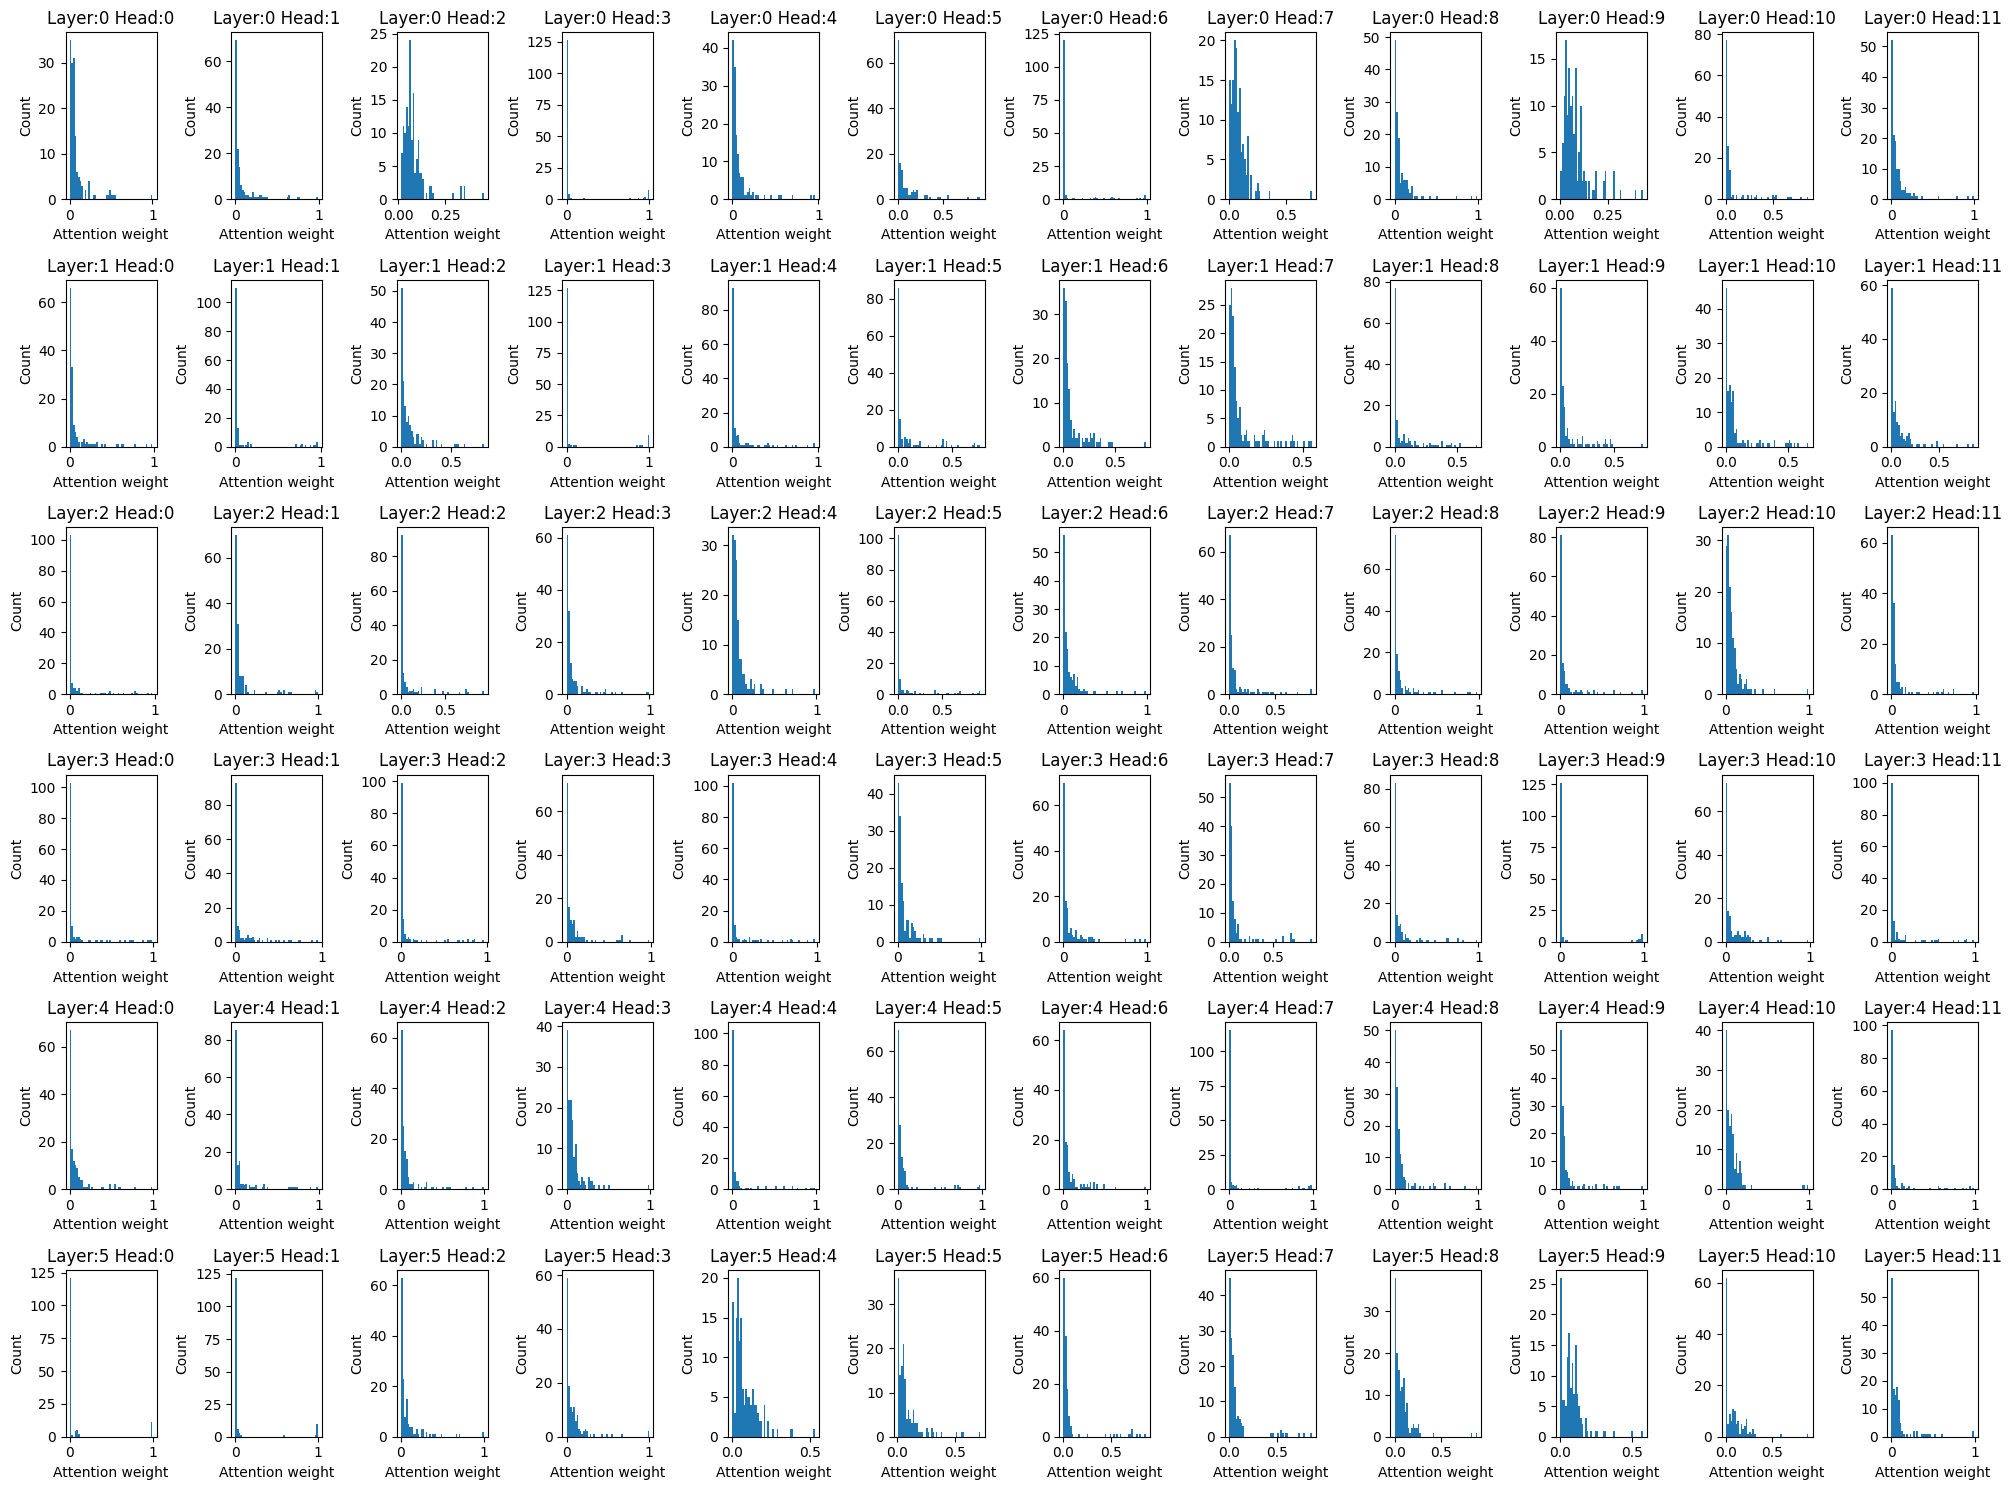

In [ ]:
import matplotlib.pyplot as plt
#hist layer vise
num_layers = len(attentions)
num_heads = attentions[0].size(1)

fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 15))

for layer_idx, layer_attn in enumerate(attentions):
    # Take first example from batch (instead of averaging)
    attn = layer_attn[0]  # shape: [num_heads, seq_len, seq_len]

    for head_idx in range(num_heads):
        values = attn[head_idx].detach().cpu().numpy().flatten()

        ax = axes[layer_idx, head_idx] if num_layers > 1 else axes[head_idx]
        ax.hist(values, bins=50)  # zoom in on [0, 0.3]
        ax.set_title(f"Layer:{layer_idx} Head:{head_idx}")
        ax.set_xlabel("Attention weight")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
!pip install bertviz --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
inputs

{'input_ids': tensor([[  101, 27400,  1813,  1865,  1228,  2503, 14419,  7747,  1152,  1225,
           119,   102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
input = inputs

In [ ]:
# Convert all sequences in batch
all_tokens = [
    tokenizer.convert_ids_to_tokens(seq.tolist())
    for seq in input["input_ids"]
]

for i, tokens in enumerate(all_tokens):
    print(f"Sequence {i} tokens:", tokens)


Sequence 0 tokens: ['[CLS]', 'Bit', '##ar', 'pulled', 'off', 'fine', 'saves', 'whenever', 'they', 'did', '.', '[SEP]']


In [ ]:
import torch
from bertviz import head_view

# choose the first sequence in batch
seq_index = 0

# stack attentions across layers into [num_layers, num_heads, seq, seq]
attention_stack = torch.stack([layer[seq_index] for layer in attentions])

# add batch dimension → [num_layers, 1, num_heads, seq, seq]
attention_stack = attention_stack.unsqueeze(1)

# tokens for that sequence
tokens = all_tokens[seq_index]

# visualize
head_view(attention_stack, tokens, sentence_b_start=None)


<IPython.core.display.Javascript object>

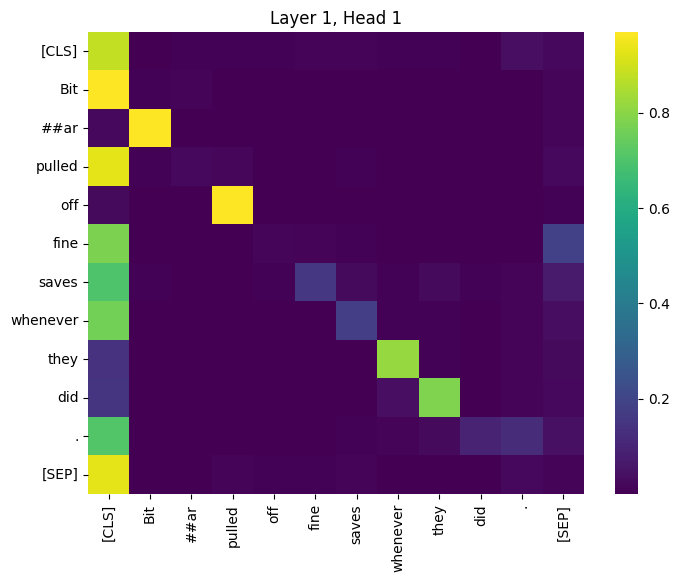

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

layer, head = 1,1
weights = attention_stack[layer, 0, head].detach().cpu()

plt.figure(figsize=(8, 6))
sns.heatmap(weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Layer {layer}, Head {head}")
plt.show()


In [ ]:
from bertviz import model_view
model_view(attention_stack,tokens)

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# ---------- 1) tokens for all sequences ----------
def tokens_for_all(inputs, tokenizer):
    all_token_lists = []
    ids = inputs["input_ids"]  # shape [batch, seq_len]
    for seq in ids:
        seq_list = seq.tolist()
        tokens = tokenizer.convert_ids_to_tokens(seq_list)
        all_token_lists.append(tokens)
    return all_token_lists

# ---------- 2) heatmap for a single layer/head ----------
def plot_attention_heatmap(attentions, inputs, tokenizer, layer=0, head=0, seq_index=0, figsize=(8,6), cmap='viridis'):
    attn = attentions[layer][seq_index, head]   # shape [seq_len, seq_len]
    attn_np = attn.detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][seq_index].tolist())

    plt.figure(figsize=figsize)
    sns.heatmap(attn_np, xticklabels=tokens, yticklabels=tokens, square=True, cbar=True, cmap=cmap)
    plt.title(f"Layer {layer} Head {head} (seq {seq_index})")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ---------- 3) grid of head heatmaps for one layer ----------
def plot_layer_heads(attentions, inputs, tokenizer, layer=0, seq_index=0, max_heads=12, figsize_per_plot=(3,3)):
    heads = attentions[layer].size(1)
    heads = min(heads, max_heads)
    cols = min(6, heads)
    rows = int(np.ceil(heads / cols))
    fig_w = cols * figsize_per_plot[0]
    fig_h = rows * figsize_per_plot[1]
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = axes.flatten()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][seq_index].tolist())

    for h in range(heads):
        ax = axes[h]
        attn_np = attentions[layer][seq_index, h].detach().cpu().numpy()
        sns.heatmap(attn_np, ax=ax, cbar=False, xticklabels=tokens, yticklabels=tokens)
        ax.set_title(f"Layer:{layer} Head:{h}")
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(heads, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# ---------- 4) histogram distributions per head ----------
def plot_histograms(attentions, seq_index=0, bins=50, value_range=(0,0.3)):
    num_layers = len(attentions)
    num_heads = attentions[0].size(1)
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads*2, num_layers*1.8))
    for l, layer_attn in enumerate(attentions):
        attn = layer_attn[seq_index]  # [heads, seq_len, seq_len]
        for h in range(num_heads):
            ax = axes[l, h] if num_layers>1 else axes[h]
            vals = attn[h].detach().cpu().numpy().flatten()
            ax.hist(vals, bins=bins, range=value_range)
            ax.set_title(f"Layer:{l} Head:{h}")
            ax.set_xlim(value_range)
            ax.set_ylim(0, None)
            ax.set_xticks([value_range[0], value_range[1]])
    plt.tight_layout()
    plt.show()

# ---------- 5) attention rollout ----------
def attention_rollout(attentions, discard_ratio=0.0):
    avg_per_layer = [layer_attn.mean(1) for layer_attn in attentions]  # [batch, seq, seq]
    batch = avg_per_layer[0].size(0)
    seq_len = avg_per_layer[0].size(1)
    device = avg_per_layer[0].device  # FIXED DEVICE
    rollouts = []
    for b in range(batch):
        joint = torch.eye(seq_len, device=device)  # FIXED DEVICE
        for L in avg_per_layer:
            A = L[b]
            if discard_ratio > 0:
                flat = A.flatten()
                thresh = torch.quantile(flat, discard_ratio)
                A = torch.where(A < thresh, torch.zeros_like(A), A)
            A = A + torch.eye(seq_len, device=A.device)  # FIXED DEVICE
            A = A / A.sum(dim=-1, keepdim=True)
            joint = A @ joint
        rollouts.append(joint.detach().cpu().numpy())
    return rollouts

def plot_rollout(rollouts, inputs, tokenizer, seq_index=0):
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][seq_index].tolist())
    mat = rollouts[seq_index]
    plt.figure(figsize=(8,6))
    sns.heatmap(mat, xticklabels=tokens, yticklabels=tokens, square=True, cbar=True)
    plt.title("Attention rollout (token influence)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ---------- 6) head similarity matrix ----------
from sklearn.metrics.pairwise import cosine_similarity
def head_similarity_matrix(attentions, layer, seq_index=0):
    layer_attn = attentions[layer][seq_index]  # [heads, seq, seq]
    H = layer_attn.size(0)
    patterns = []
    for h in range(H):
        pat = layer_attn[h].detach().cpu().numpy().flatten()
        patterns.append(pat)
    sim = cosine_similarity(patterns)
    return sim

def plot_head_similarity(sim, layer):
    plt.figure(figsize=(6,5))
    sns.heatmap(sim, annot=True, fmt=".2f")
    plt.title(f"Head similarity (Layer {layer})")
    plt.xlabel("Head")
    plt.ylabel("Head")
    plt.tight_layout()
    plt.show()

# ---------- 7) per-head CLS mass ----------
def cls_mass_per_head(attentions, inputs, cls_index=0, seq_index=0):
    masses = []
    for l, layer_attn in enumerate(attentions):
        a = layer_attn[seq_index]  # [heads, seq, seq]
        mass_to_cls = a[:, :, cls_index].sum(axis=1).detach().cpu().numpy()
        masses.append(mass_to_cls)
    return np.stack(masses, axis=0)  # [layers, heads]

def plot_cls_mass(mass_matrix):
    layers, heads = mass_matrix.shape
    plt.figure(figsize=(heads*0.5 + 3, layers*0.4 + 2))
    sns.heatmap(mass_matrix, annot=False, cmap='magma')
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.title("Per-head mass attending TO CLS (rows=layers)")
    plt.tight_layout()
    plt.show()


batch size: 1


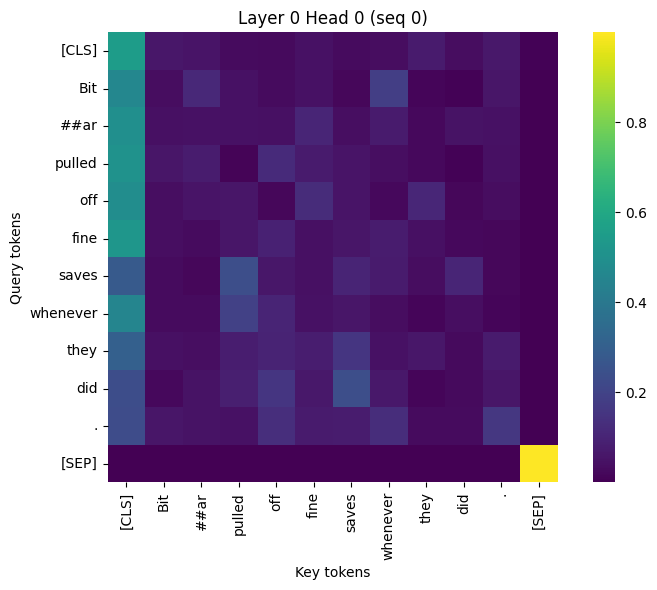

In [ ]:
# assume tokenizer, model loaded; inputs tokenized; outputs computed
attentions = output.attentions
all_tokens = tokens_for_all(input, tokenizer)
print("batch size:", len(all_tokens))

# Plot a single heatmap
plot_attention_heatmap(attentions, input, tokenizer, layer=0, head=0, seq_index=0)



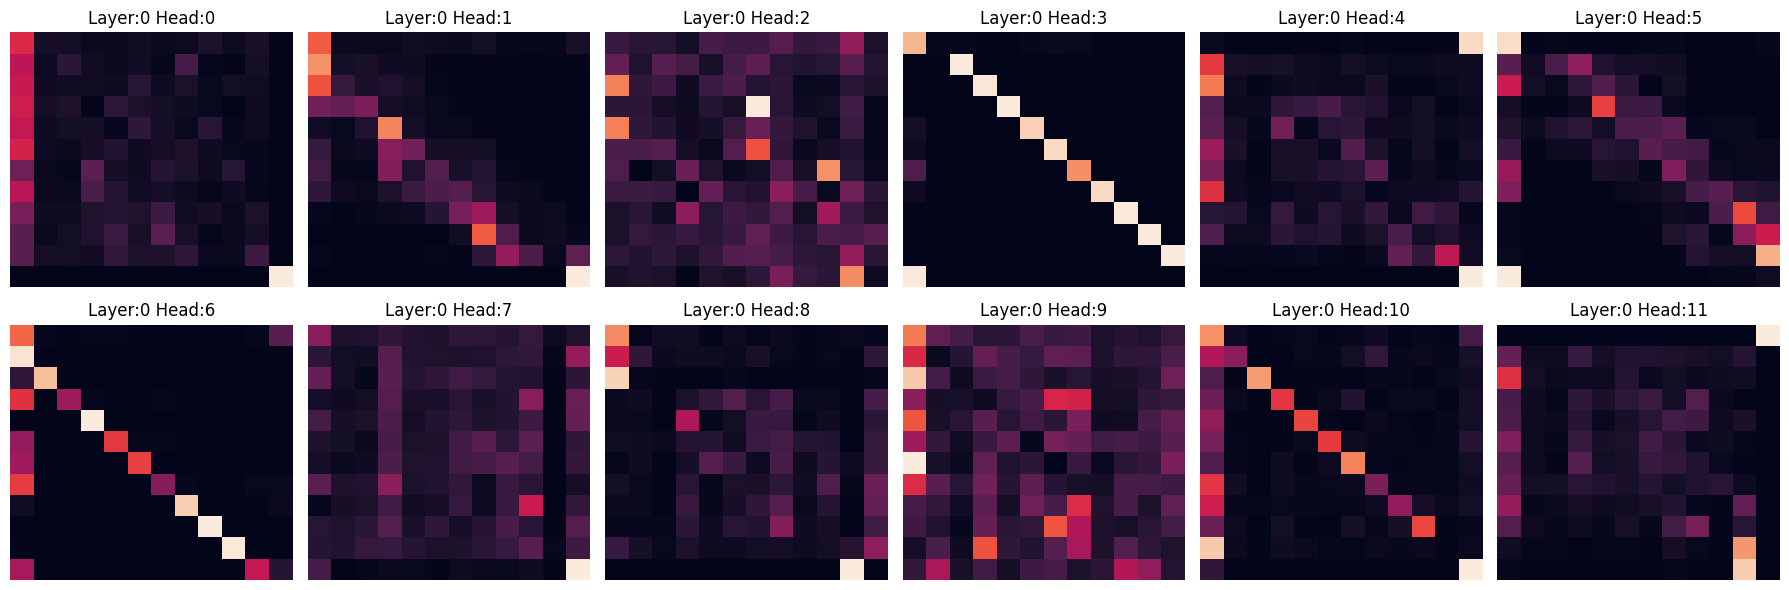

In [ ]:
# Plot grid of heads for layer 0, example 0
plot_layer_heads(attentions, input, tokenizer, layer=0, seq_index=0)



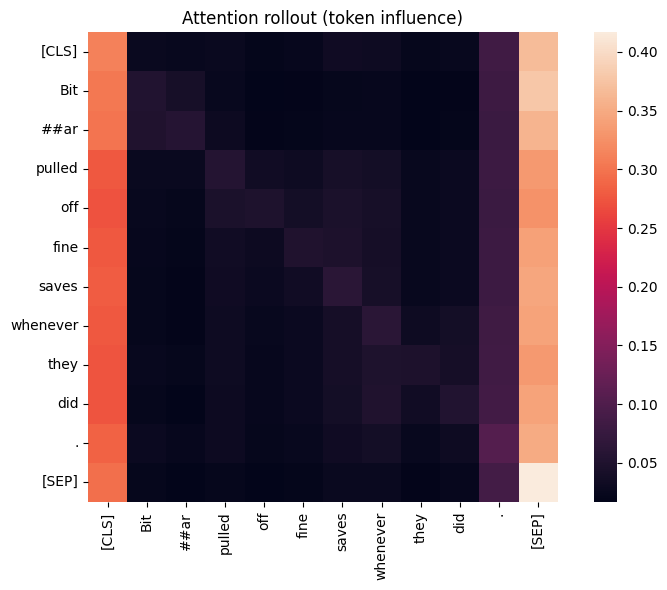

In [ ]:
# Attention rollout and plot
rollouts = attention_rollout(attentions, discard_ratio=0.0)
plot_rollout(rollouts, input,tokenizer=tokenizer, seq_index=0)



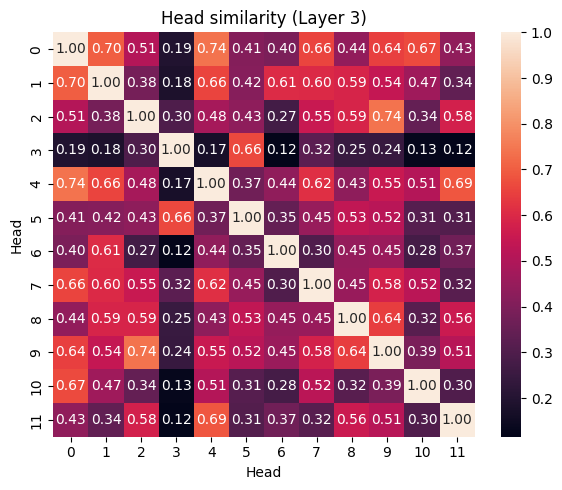

In [ ]:
# Head similarity & visualization
sim = head_similarity_matrix(attentions, layer=0, seq_index=0)
plot_head_similarity(sim, layer=3)


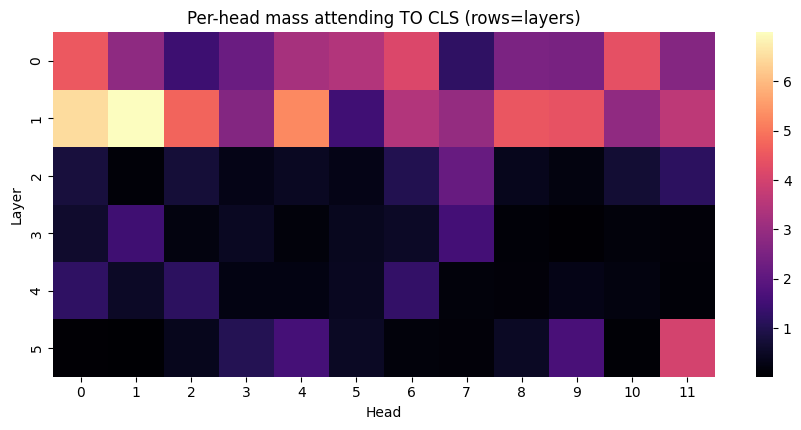

In [ ]:

# CLS mass across layers
mass = cls_mass_per_head(attentions, input, cls_index=0, seq_index=0)
plot_cls_mass(mass)

In [ ]:
!pip install captum --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


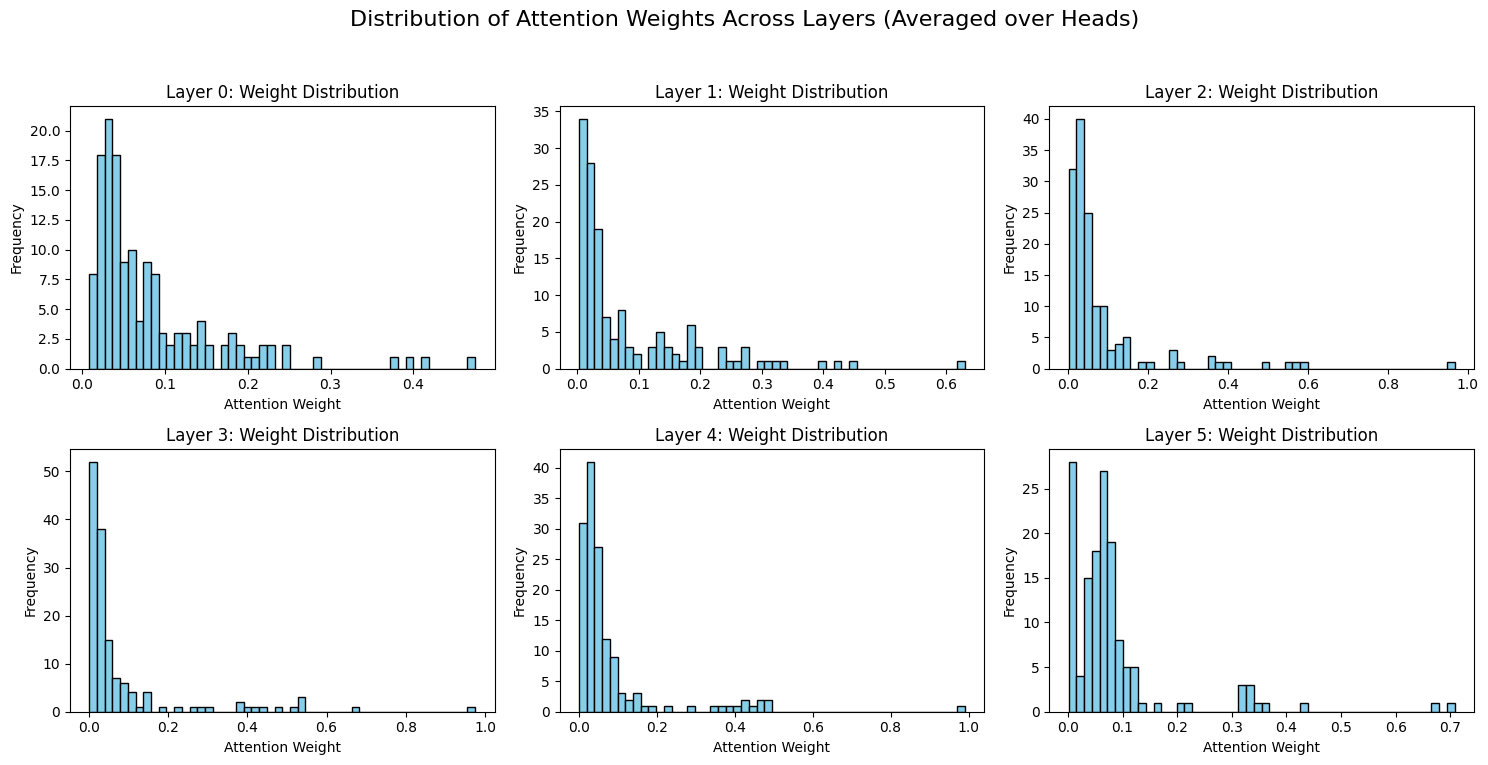

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_attention in enumerate(attentions):
    # Get attention for the first (and only) item in the batch
    # and average across all heads: shape becomes [seq_len, seq_len]
    layer_attention_avg = layer_attention[0].mean(dim=0)

    # Flatten the matrix to get a 1D array of weights
    weights = layer_attention_avg.detach().cpu().numpy().flatten()

    ax = axes[i]
    ax.hist(weights, bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Layer {i}: Weight Distribution')
    ax.set_xlabel('Attention Weight')
    ax.set_ylabel('Frequency')

plt.suptitle('Distribution of Attention Weights Across Layers (Averaged over Heads)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

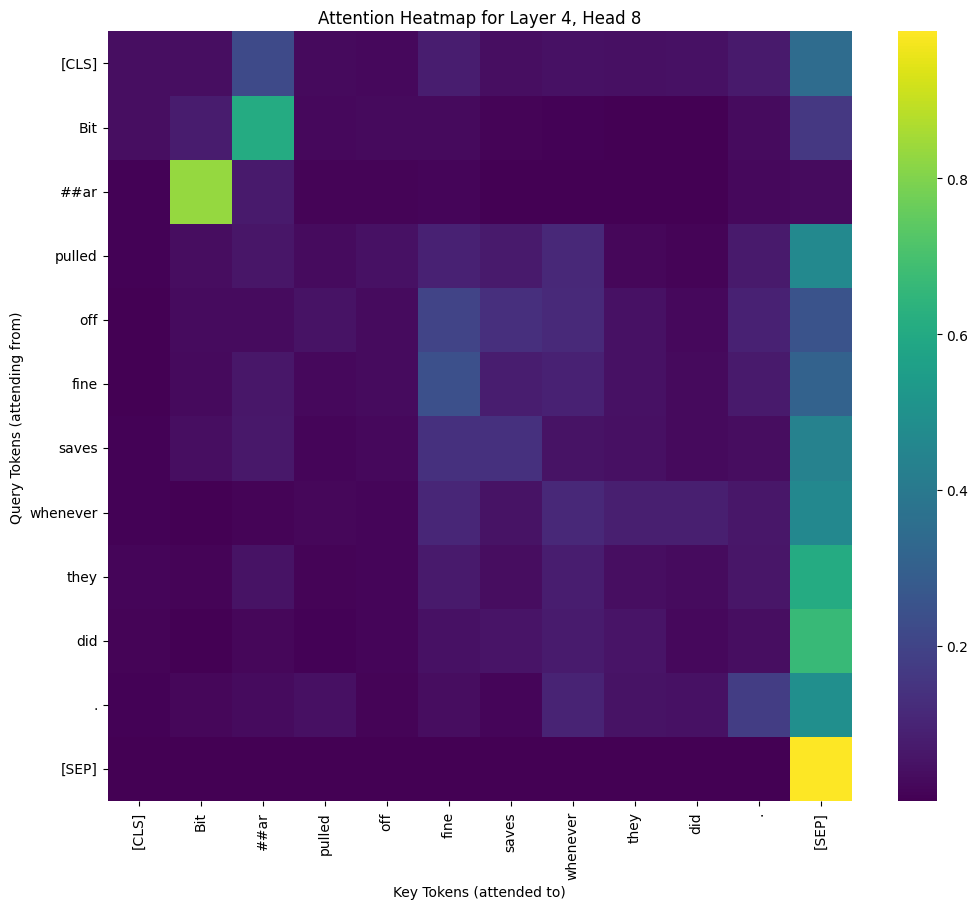

In [ ]:
# --- You can change these values to explore different layers/heads ---
LAYER_TO_VISUALIZE = 4
HEAD_TO_VISUALIZE = 8
# -------------------------------------------------------------------

# Get attention weights for the specific layer and head
attention_weights = attentions[LAYER_TO_VISUALIZE][0, HEAD_TO_VISUALIZE].detach().cpu().numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f'Attention Heatmap for Layer {LAYER_TO_VISUALIZE}, Head {HEAD_TO_VISUALIZE}')
plt.xlabel("Key Tokens (attended to)")
plt.ylabel("Query Tokens (attending from)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

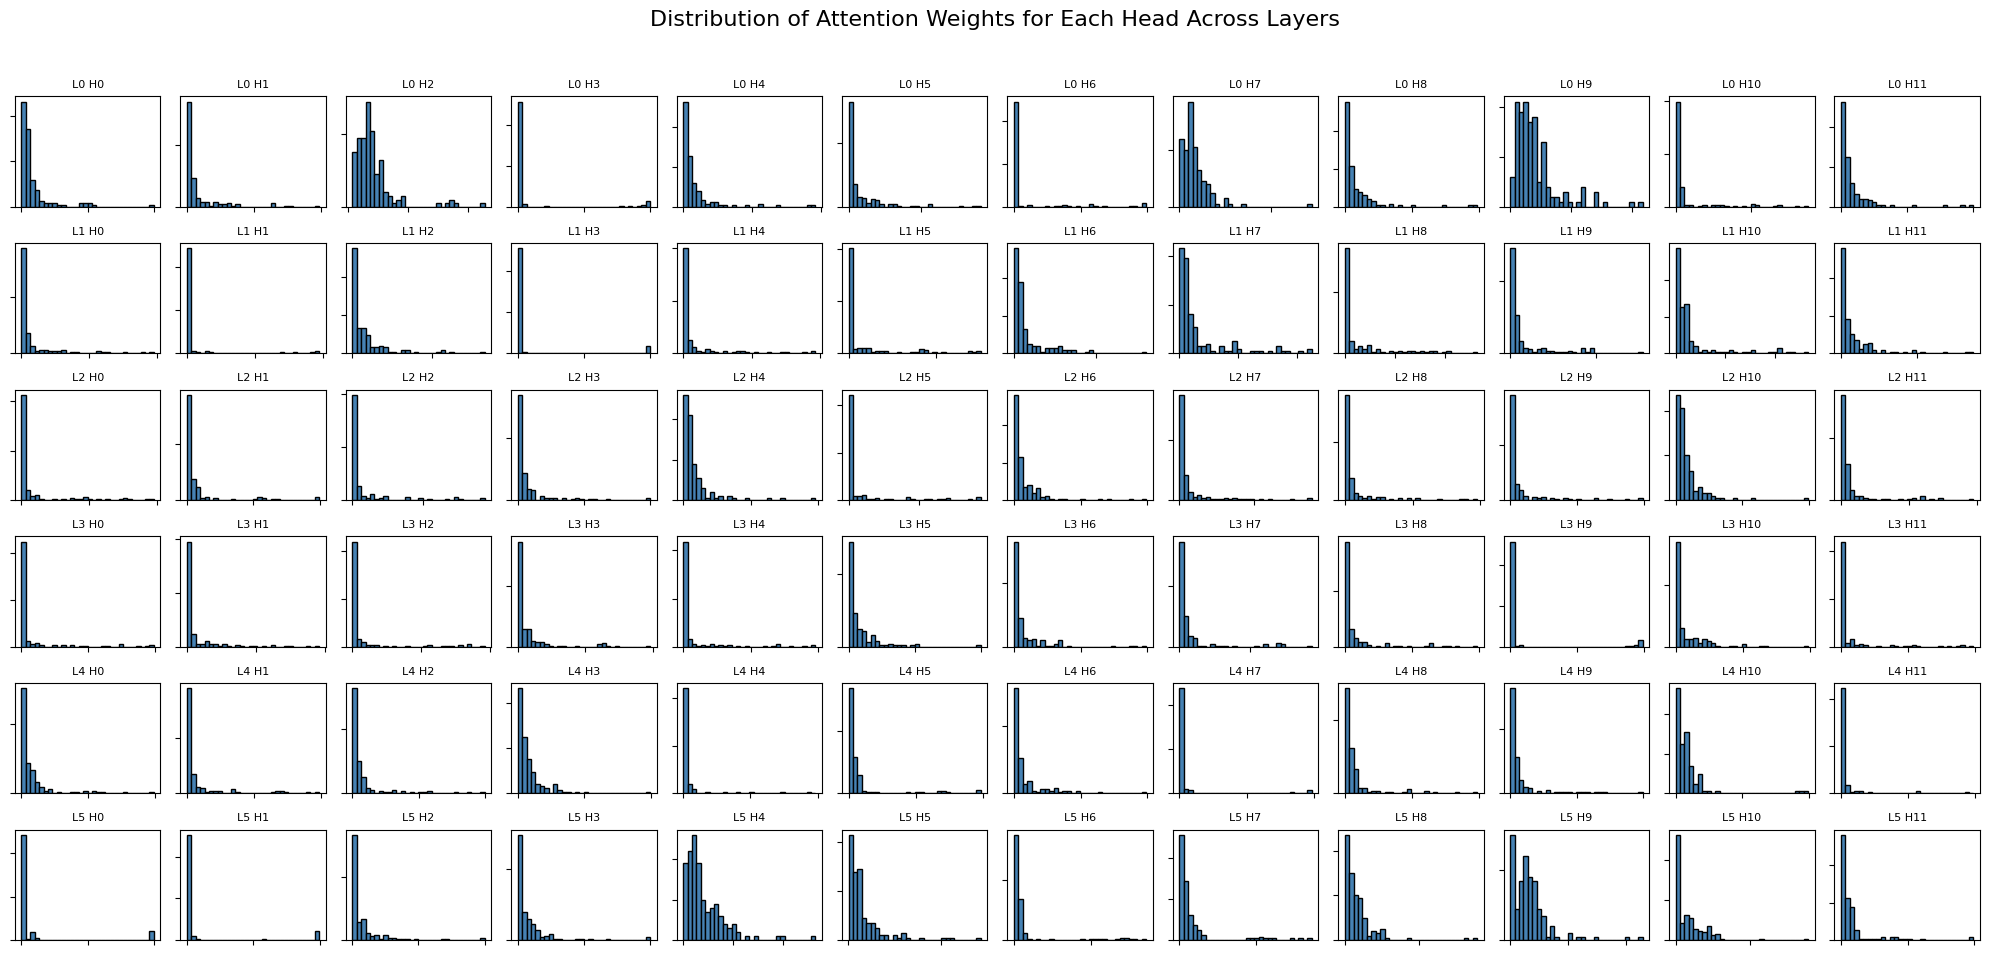

In [ ]:
# --- Plot 1 (Revised): Histogram for Each Head in Each Layer ---
num_layers = len(attentions)
num_heads = attentions[0].size(1) # Number of heads in the first layer

fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 10))

for layer_idx, layer_attention in enumerate(attentions):
    # Get attention for the first (and only) item in the batch
    attention_for_seq = layer_attention[0] # Shape: [num_heads, seq_len, seq_len]

    for head_idx in range(num_heads):
        # Get the specific head's attention matrix and flatten it
        head_weights = attention_for_seq[head_idx].detach().cpu().numpy().flatten()

        ax = axes[layer_idx, head_idx]
        ax.hist(head_weights, bins=30, color='steelblue', edgecolor='black')
        ax.set_title(f'L{layer_idx} H{head_idx}', fontsize=8)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

plt.suptitle('Distribution of Attention Weights for Each Head Across Layers', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [ ]:
!pip install shap lime spacy -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.5 MB/s eta 0:00:00
^C
ERROR: Operation cancelled by user


conll2003/train/0000.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/283k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Label names: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
Original example:
Tokens: ['He', 'was', 'well', 'backed', 'by', 'England', 'hopeful', 'Mark', 'Butcher', 'who', 'made', '70', 'as', 'Surrey', 'closed', 'on', '429', 'for', 'seven', ',', 'a', 'lead', 'of', '234', '.']
True labels: ['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: He was well backed by England hopeful Mark Butcher who made 70 as Surrey closed on 429 for seven , a lead of 234 .

1. BASIC INFERENCE RESULTS
Token-by-token analysis:
'He': Pred=O
'was': Pred=O
'well': Pred=O
'backed': Pred=O
'by': Pred=O
'England': Pred=B-LOC
'hopeful': Pred=O
'Mark': Pred=B-PER
'Butcher': Pred=I-PER
'who': Pred=O
'made': Pred=O
'70': Pred=O
'as': Pred=O
'Surrey': Pred=B-ORG
'closed': Pred=O
'on': Pred=O
'42': Pred=O
'##9': Pred=O
'for': Pred=O
'seven': Pred=O
',': Pred=O
'a': 

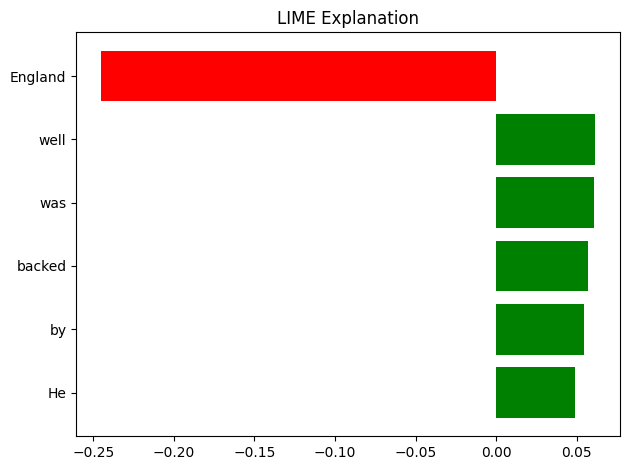


4. NER VISUALIZATION
TRUE LABELS:
He was well backed by England(B-LOC) hopeful Mark(B-PER) Butcher(I-PER) who made 70 as Surrey(B-ORG) closed on 429 for seven , a lead of 234 .

PREDICTED LABELS:
He was well backed by England(B-LOC) hopeful Mark(B-PER) Butcher(I-PER) who made 70 as Surrey(B-ORG) closed on 429 for seven , a lead of 234 .



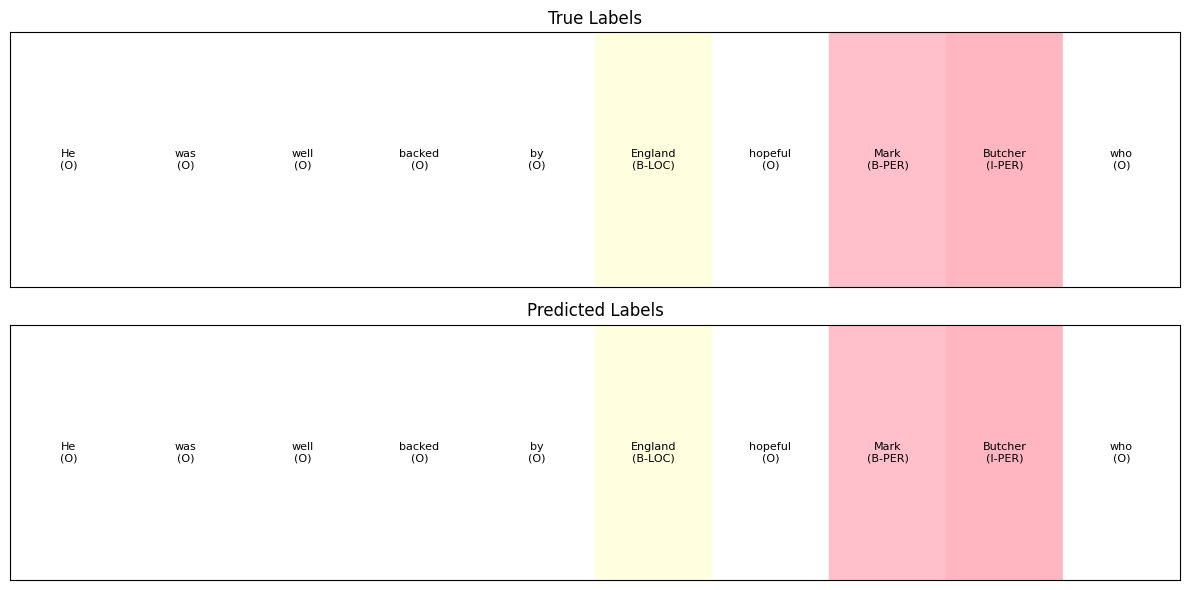


5. SUMMARY STATISTICS
Token-level Accuracy: 100.00%
Correct: 25/25

True label distribution:
  O: 21
  B-LOC: 1
  B-PER: 1
  I-PER: 1
  B-ORG: 1

Predicted label distribution:
  O: 21
  B-LOC: 1
  B-PER: 1
  I-PER: 1
  B-ORG: 1

Entity-level analysis:
PER: True=2, Pred=2
ORG: True=1, Pred=1
LOC: True=1, Pred=1
MISC: True=0, Pred=0


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
import shap
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from collections import Counter

# Your existing setup
tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")
ds = load_dataset("conll2003",revision="convert/parquet")  # Using the official conll2003 dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Get label names from the model config
label_names = model.config.id2label
print("Label names:", label_names)

# Take one example from the validation set
example_idx = 10  # Try a different index
example = ds['validation'][example_idx]
tokens = example['tokens']
true_labels = example['ner_tags']

print("Original example:")
print(f"Tokens: {tokens}")
print(f"True labels: {[label_names[label] for label in true_labels]}")

# Prepare text for explanation
text = " ".join(tokens)
print(f"\nText: {text}")

# 1. Run basic inference and display results
print("\n" + "="*50)
print("1. BASIC INFERENCE RESULTS")
print("="*50)

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, return_offsets_mapping=True)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=2)

# Convert to human readable
predicted_labels = predictions[0].cpu().numpy()
tokenized_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print("Token-by-token analysis:")
for i, (token, pred_label) in enumerate(zip(tokenized_tokens, predicted_labels)):
    if token not in ['[CLS]', '[SEP]', '[PAD]']:
        print(f"'{token}': Pred={label_names[pred_label]}")

# Align predictions with original tokens
# This is tricky because of tokenization differences, so we'll use a simpler approach
print(f"\nAligned predictions (first {len(tokens)} tokens):")
aligned_predictions = predicted_labels[1:len(tokens)+1]  # Skip CLS token
for token, true_label, pred_label in zip(tokens, true_labels, aligned_predictions):
    print(f"'{token}': True={label_names[true_label]}, Pred={label_names[pred_label]}")

# 2. SHAP Explanation
print("\n" + "="*50)
print("2. SHAP EXPLANATION")
print("="*50)

try:
    # Simplified prediction function for SHAP
    def predict_ner(texts):
        model.eval()
        batch_probs = []

        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                             padding=True, max_length=128).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            probs = torch.nn.functional.softmax(logits, dim=-1)
            # Remove batch dimension and take first few tokens to avoid memory issues
            batch_probs.append(probs[0, 1:min(10, probs.shape[1]), :].cpu().numpy())

        return np.concatenate(batch_probs, axis=0)

    # Create SHAP explainer
    explainer = shap.Explainer(predict_ner, tokenizer)

    # Compute SHAP values for a shorter text to avoid memory issues
    short_text = " ".join(tokens[:8])  # Use first 8 tokens
    shap_values = explainer([short_text])

    # Visualize SHAP
    print(f"SHAP visualization for: {short_text}")
    shap.plots.text(shap_values[0], display=False)
    plt.title("SHAP Explanation")
    plt.show()

except Exception as e:
    print(f"SHAP failed: {e}")
    print("This is common due to memory constraints. Let's try a simpler approach...")

# 3. LIME Explanation
print("\n" + "="*50)
print("3. LIME EXPLANATION")
print("="*50)

try:
    # Prediction function for LIME
    def predict_proba(texts):
        model.eval()
        all_probs = []

        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                             padding=True, max_length=128).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            probs = torch.nn.functional.softmax(logits, dim=-1)
            # Average probabilities across tokens (excluding special tokens)
            token_probs = probs[0, 1:-1, :]  # Skip [CLS] and [SEP]
            if token_probs.shape[0] > 0:
                avg_probs = token_probs.mean(dim=0).cpu().numpy()
            else:
                avg_probs = np.zeros(probs.shape[-1])
            all_probs.append(avg_probs)

        return np.array(all_probs)

    lime_explainer = LimeTextExplainer(class_names=list(label_names.values()))

    # Explain a shorter text
    short_text = " ".join(tokens[:6])
    exp = lime_explainer.explain_instance(
        short_text,
        predict_proba,
        num_features=6,
        top_labels=3
    )

    print("LIME Explanation:")
    print(f"Top label: {list(label_names.values())[exp.top_labels[0]]}")
    for feature, weight in exp.as_list(label=exp.top_labels[0]):
        print(f"{feature}: {weight:.4f}")

    # Show LIME plot
    exp.as_pyplot_figure(label=exp.top_labels[0])
    plt.title(f"LIME Explanation")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"LIME failed: {e}")

# 4. NER Visualization
print("\n" + "="*50)
print("4. NER VISUALIZATION")
print("="*50)

# Create a simple text-based visualization
def visualize_ner_simple(tokens, labels, title="NER Results"):
    colors = {
        'B-PER': '\033[95m', 'I-PER': '\033[95m',  # Magenta
        'B-ORG': '\033[94m', 'I-ORG': '\033[94m',  # Blue
        'B-LOC': '\033[93m', 'I-LOC': '\033[93m',  # Yellow
        'B-MISC': '\033[91m', 'I-MISC': '\033[91m',  # Red
        'O': '\033[0m'  # Reset
    }
    reset_color = '\033[0m'

    print(f"{title}:")
    result = []
    for token, label_id in zip(tokens, labels):
        label = label_names[label_id]
        color = colors.get(label, '\033[0m')
        if label != 'O':
            result.append(f"{color}{token}({label}){reset_color}")
        else:
            result.append(token)
    print(" ".join(result))
    print()

# Visualize true and predicted labels
visualize_ner_simple(tokens, true_labels, "TRUE LABELS")
visualize_ner_simple(tokens, aligned_predictions, "PREDICTED LABELS")

# Alternative: Create a color-coded display using matplotlib
def plot_ner_comparison(tokens, true_labels, pred_labels):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    # Color mapping
    color_map = {
        'B-PER': 'pink', 'I-PER': 'lightpink',
        'B-ORG': 'lightblue', 'I-ORG': 'lightcyan',
        'B-LOC': 'lightyellow', 'I-LOC': 'lemonchiffon',
        'B-MISC': 'lightcoral', 'I-MISC': 'mistyrose',
        'O': 'white'
    }

    # Plot true labels
    y_pos = 0
    for i, (token, label_id) in enumerate(zip(tokens, true_labels)):
        label = label_names[label_id]
        color = color_map.get(label, 'white')
        ax1.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
        ax1.text(i + 0.5, 0.5, f"{token}\n({label})",
                ha='center', va='center', fontsize=8)
        ax1.set_xlim(0, len(tokens))
        ax1.set_ylim(0, 1)
        ax1.set_title('True Labels')
        ax1.set_xticks([])
        ax1.set_yticks([])

    # Plot predicted labels
    for i, (token, label_id) in enumerate(zip(tokens, pred_labels)):
        label = label_names[label_id]
        color = color_map.get(label, 'white')
        ax2.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
        ax2.text(i + 0.5, 0.5, f"{token}\n({label})",
                ha='center', va='center', fontsize=8)
        ax2.set_xlim(0, len(tokens))
        ax2.set_ylim(0, 1)
        ax2.set_title('Predicted Labels')
        ax2.set_xticks([])
        ax2.set_yticks([])

    plt.tight_layout()
    plt.show()

# Create the comparison plot
plot_ner_comparison(tokens[:10], true_labels[:10], aligned_predictions[:10])

# 5. Summary Statistics
print("\n" + "="*50)
print("5. SUMMARY STATISTICS")
print("="*50)

# Calculate accuracy
correct = sum(1 for t, p in zip(true_labels, aligned_predictions) if t == p)
accuracy = correct / len(true_labels)

print(f"Token-level Accuracy: {accuracy:.2%}")
print(f"Correct: {correct}/{len(true_labels)}")

# Label distribution
true_counter = Counter([label_names[l] for l in true_labels])
pred_counter = Counter([label_names[l] for l in aligned_predictions])

print("\nTrue label distribution:")
for label, count in true_counter.most_common():
    print(f"  {label}: {count}")

print("\nPredicted label distribution:")
for label, count in pred_counter.most_common():
    print(f"  {label}: {count}")

# Confusion matrix for major entity types
print("\nEntity-level analysis:")
entity_types = ['PER', 'ORG', 'LOC', 'MISC']

for entity_type in entity_types:
    true_entities = sum(1 for label in true_labels if label_names[label].endswith(entity_type))
    pred_entities = sum(1 for label in aligned_predictions if label_names[label].endswith(entity_type))
    print(f"{entity_type}: True={true_entities}, Pred={pred_entities}")